In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("../incl/")

-685.1335676506301


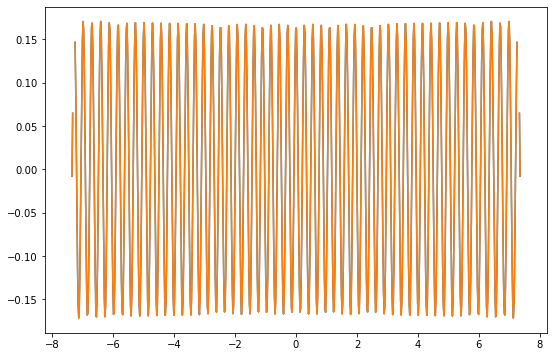

In [145]:
from scipy.special import eval_hermite

def get_N(n):
    return 1./np.sqrt( np.sqrt(np.pi) * (2**n) * np.math.factorial(n))

x = np.linspace(-10,10,1000)
dx = x[1]-x[0]

n = 260

h = eval_hermite(n,x) * np.exp(-0.5*x**2)

# H = get_N(n) * h 


def get_logN(n):
    n = float(n)
    return -0.5 * ( n*np.log(2.) + n*np.log(n) - n + 0.5*np.log(2.*np.pi*n) + 0.5*np.log(np.pi) )

print(get_logN(n))
# print(np.log(get_N(n)))


Htest2 = h * np.exp(get_logN(n))


signs = np.sign(h)

Htest3 = signs*np.exp( np.log(signs*h) + get_logN(n))

# print(h)



# plt.plot(x,H)
plt.plot(x, Htest2 )
plt.plot(x, Htest3 )
plt.show()

In [31]:

x = np.linspace(-100,100,10001)
x = x[1:]
dx = x[1]-x[0]

# print(x)

n1 = 80
n2 = 0

inner = get_N(n1)*eval_hermite(n1,x) @ ( get_N(n2)*eval_hermite(n2,x) * np.exp(-x**2) * dx)

print(inner)


-1.4276396724208222e-15


In [116]:
import ELPH_utils
runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')
# runs = runs[:100:1]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

data_matrix = np.concatenate(runs, axis=1)

1000 loaded with n_kmax = 200


In [117]:
from ELPH_Dim_Reducer import Hermite


HermiteReducer = Hermite(sample_max=1.3,sorted=True, optimize=True, orthogonalize=True)

HermiteReducer.train(data_matrix)

# plt.plot(HermiteReducer.H_matrix[119])
# plt.plot(HermiteReducer.H_matrix[118])
# plt.show()

print('H matrix rank:', np.linalg.matrix_rank(HermiteReducer.H_matrix))

# U,S,V = np.linalg.svd(HermiteReducer.H_matrix.T)
# plt.semilogy(S, 'o')
# plt.show()

# plt.plot(HermiteReducer.mean_coefs,'o')
# plt.show()

# plt.grid()
# plt.plot(np.abs(HermiteReducer.mean_coefs[HermiteReducer.sort_inds]),'o')
# plt.show()


H matrix rank: 200


sample max: 1.8080572081769333
H matrix rank: 80
0.0


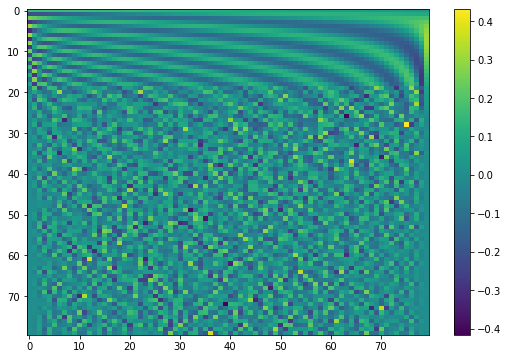

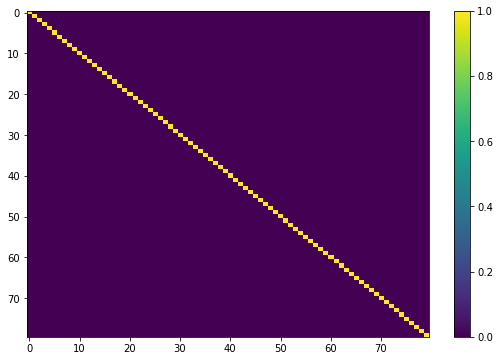

In [115]:
print('sample max:', HermiteReducer.sample_max)

print('H matrix rank:', np.linalg.matrix_rank(HermiteReducer.H_matrix))


print(HermiteReducer.H_matrix[0] @ HermiteReducer.H_matrix[1])


plt.imshow(HermiteReducer.H_matrix, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


plt.imshow(HermiteReducer.H_matrix.T @ HermiteReducer.H_matrix, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()




O matrix rank: 36


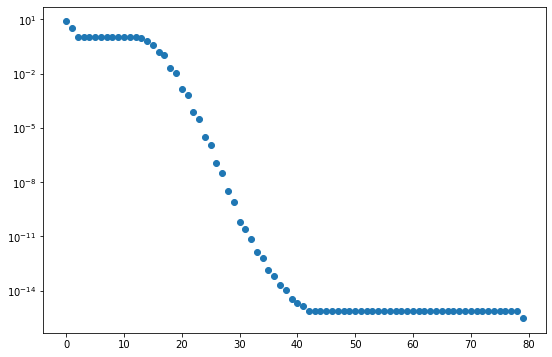

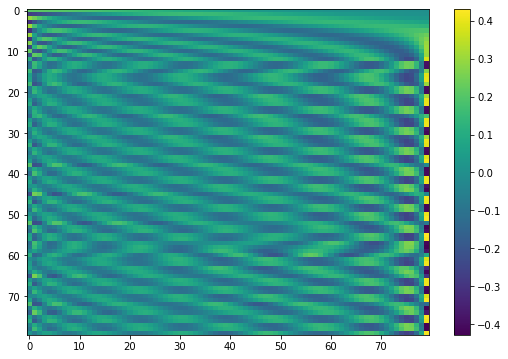

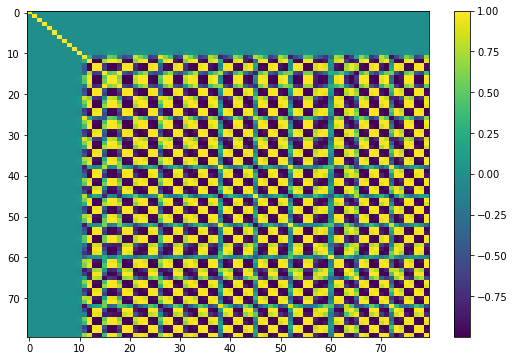

O matrix rank: 80


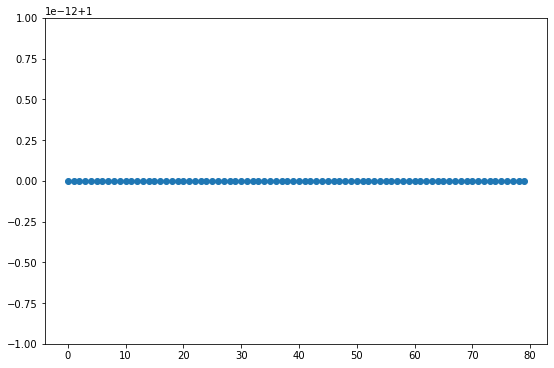

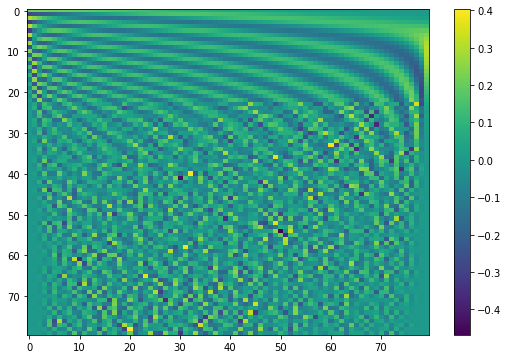

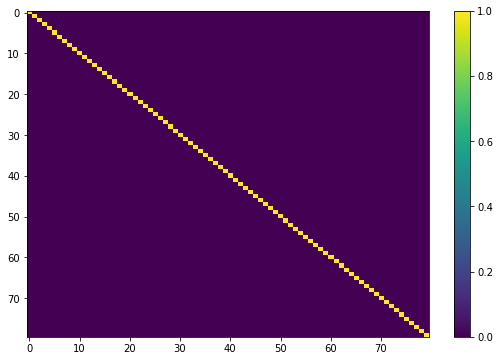

In [113]:

def GramSchmidt(A):
    M = A.shape[0]
    N = A.shape[1]
    assert(M >= N)
    Q = np.zeros((M,N))
    for k in range(0,N):
        Q[:,k] = A[:,k]
        print(Q[:,:k].shape)
        print(A[:,k].shape)
        Q[:,k] = Q[:,k] - np.dot(Q[:,:k],np.dot(A[:,k],Q[:,:k]))
        Q[:,k] = (1.0 / np.linalg.norm(Q[:,k])) * Q[:,k]
    return Q


def GramSchmidt_Rows(A, eps=0.0):
    M = A.shape[0]
    N = A.shape[1]
    assert(M <= N)
    Q = np.zeros((M,N))
    for k in range(0,M):
        Q[k] = A[k]
        for j in range(k):
            Q[k] = Q[k] - np.dot(Q[j],A[k])*Q[j]
            
        if (Q[k] > eps).any():
            Q[k] = Q[k] / np.linalg.norm(Q[k])
        else:
            Q[k] = 0.0
    return Q


# O = GramSchmidt(HermiteReducer.H_matrix.T).T

O = GramSchmidt_Rows(HermiteReducer.H_matrix, eps=0)

print('O matrix rank:', np.linalg.matrix_rank(O))

U,S,V = np.linalg.svd(O.T)
plt.semilogy(S,'o')
plt.show()

plt.imshow(O, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(O @ O.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


O = GramSchmidt_Rows(O, eps=0)


def nGS(O, n=1):
    mGS = O.copy()
    for k in range(n):
        mGS =  GramSchmidt_Rows(mGS)
    return mGS
    

O = nGS(O,10)

print('O matrix rank:', np.linalg.matrix_rank(O))

U,S,V = np.linalg.svd(O.T)
plt.plot(S,'o')
plt.show()

plt.imshow(O, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(O @ O.T, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()



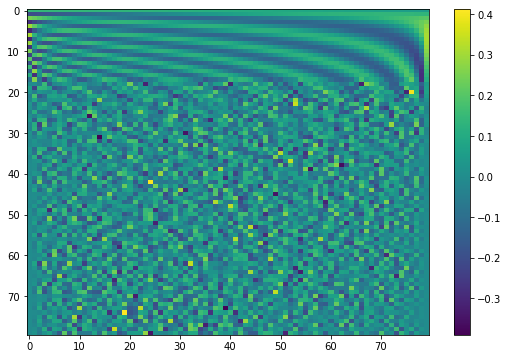

(40, 400)
(80, 400)


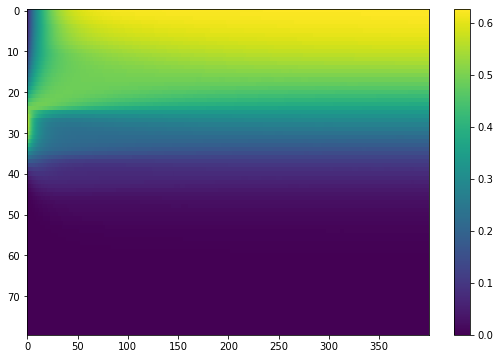

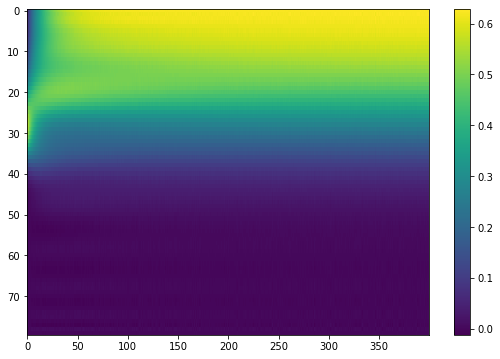

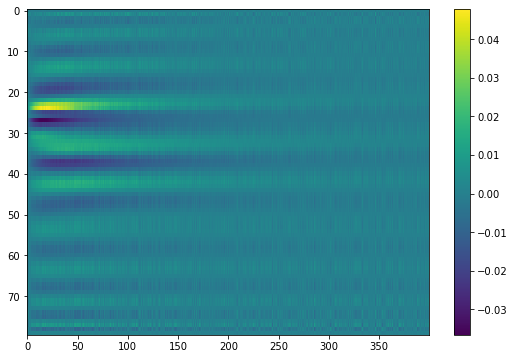

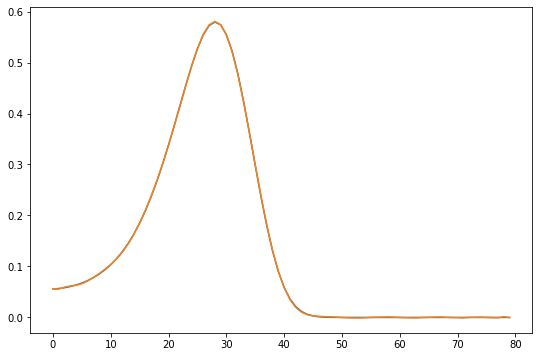

In [13]:
test = runs[55]


HermiteReducer.H_matrix = O

plt.imshow(HermiteReducer.H_matrix, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


red_coef_matrix = HermiteReducer.reduce(test,40)
print(red_coef_matrix.shape)

recon = HermiteReducer.expand(red_coef_matrix)
print(recon.shape)




plt.imshow(test, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(recon, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(test - recon, aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

plt.plot(test[:,0])
plt.plot(recon[:,0])
plt.show()


# plt.imshow(np.abs(red_coef_matrix), aspect='auto', interpolation='none')
# plt.colorbar()
# plt.show()